# Convert Geopandas GeoSeries to spherical harmonics 
Author: R. Rietbroek Dec 2024 (r.rietbroek@utwente.nl)*




## 1. Preparations

In [1]:
#Optionally enable autoreloading for development purposes. Note that this does not automagically reload the binary extensions
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import os
import shxarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import numpy as np
import geopandas as gpd
from shapely import Point

In [12]:
#set the maximum degree of the output spherical harmonics
nmax=120

## 2. Get a set of Antartic grounded drainage basins (as polygons) to use as continental loads

Text(0.5, 1.0, 'Antarctic grounded drainage basins')

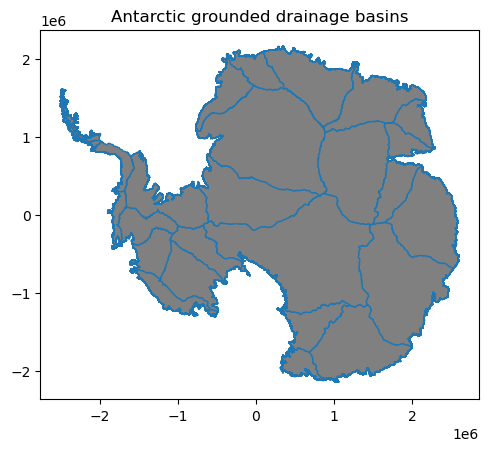

In [4]:
# In this example we're loading the drainage basin outlines froma geoslurp database
# The original datasources can be found at https://earth.gsfc.nasa.gov/cryo/data/polar-altimetry/antarctic-and-greenland-drainage-systems
from geoslurp.manager import GeoslurpManager
import geoslurp.tools.pandas  
import pandas as pd
gsman=GeoslurpManager(dbalias="tunnelmarge")
tname="cryo.antarc_ddiv_icesat_grnd"

# One can populate the database like this:
#dsant=gsman.dataset(tname)
#dsant.pull()
#dsant.register()

#load the polygons from the databse in a geopandas dataframe NOTE: convert to polar stereographic projection because the polgyon contains the south Pole
#And this projection is needed when converting to spherical harmonics
dfant=pd.DataFrame.gslrp.load(gsman.conn,f"SELECT basinid,ST_transform(geom::geometry,3031) as geometry FROM {tname}")
# quick plot of the drainage basin outlines
ax=dfant.plot(edgecolor="tab:blue",facecolor="grey")
ax.set_title("Antarctic grounded drainage basins")

## 3 Convert the drainage outline to spherical harmonics of the desired degrees
We take the column `basinid` as an axiliary coordinate to indicate the original geometries present


In [13]:
dantsh=xr.DataArray.sh.from_geoseries(dfant.geometry,nmax,auxcoord=dfant.basinid)
dantsh.name='ant_div'
display(dantsh)

#optionally save to disk
fout=f"data/antarc_ddiv_icesat_grnd_n{nmax}.nc"
# dantsh.reset_index('nm').to_netcdf(fout)

shxarray-INFO: Masking and gridding polygons
shxarray-INFO: Applying SH analysis


<xarray.DataArray 'ant_div' (basinid: 26, nm: 14641)> Size: 3MB
array([[ 9.35249879e-004, -2.98417988e-004, -1.58836940e-003, ...,
        -6.73740082e-071, -8.24373566e-072,  1.57643357e-073],
       [ 1.51642372e-003, -4.08984702e-005, -2.61911845e-003, ...,
         2.38210395e-101, -1.68832323e-103,  4.94768085e-107],
       [ 3.04177662e-003,  1.42272790e-004, -5.18789693e-003, ...,
        -4.39038248e-072,  1.05337136e-073, -1.66245556e-075],
       ...,
       [ 1.98102086e-004, -9.48620912e-005, -3.27591542e-004, ...,
         6.99449283e-058, -2.03177167e-060, -4.84564443e-061],
       [ 5.69892029e-005, -3.49694318e-005, -9.06381789e-005, ...,
        -1.58534500e-046, -7.16860463e-046,  2.58137837e-047],
       [ 7.57868335e-005, -4.60878341e-005, -1.20652495e-004, ...,
        -5.30623439e-046, -3.91274031e-050,  7.26843713e-049]],
      shape=(26, 14641))
Coordinates:
  * basinid  (basinid) float64 208B 2.0 3.0 4.0 5.0 6.0 ... 24.0 25.0 26.0 27.0
  * nm       (nm) object 117kB MultiIndex
  * n        (nm) int64 117kB 0 1 1 1 2 2 2 2 ... 120 120 120 120 120 120 120
  * m        (nm) int64 117kB 0 -1 0 1 -2 -1 0 1 ... 114 115 116 117 118 119 120

## 4 Check if the intermediate drainage basin results made sense
A spatially discontinuous function cannnot be one-to-one mapped to spectrally truncated function, so some Gibb's phenomena is to be expected


Text(0.5, 1.0, 'Antarctic drainage basin 18 from sh nmax=120')

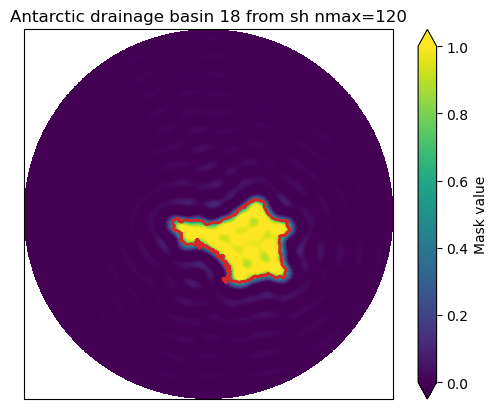

In [14]:
# Sum all spherical harmonic coefficient sets for all basins and grid
import cartopy.crs as ccrs
dres=0.25
basinid=18
# basinid=3
daantgrd=dantsh.sel(basinid=basinid).sh.synthesis(lon=np.arange(-180+dres/2,180,dres),lat=np.arange(-90+dres/2,-60,dres))
daantgrd.name="Mask value"
# daantgrd=daantgrd[daantgrd.lat < -50]
ax = plt.axes(projection=ccrs.SouthPolarStereo())
daantgrd.plot(ax=ax,vmax=1,vmin=0,transform=ccrs.PlateCarree())
ax.add_geometries(dfant[dfant.basinid==basinid].geometry,edgecolor='tab:red',crs=ccrs.SouthPolarStereo(),facecolor="none",lw=2)
plt.title(f"Antarctic drainage basin {basinid} from sh nmax={nmax}")

## 5 What about the conversion of geometry points?
Points can be interpreted as **unit loads, disks or parabolic loads**, before being expanded into spherical harmonic coefficients.
Let's create some randomized points on the sphere first


In [15]:
from random import sample
npoints=100
latrange=180
lonrange=360
discr=0.001245
latpnt=sample(sorted(np.arange(-90,90,discr)),npoints)
lonpnt=sample(sorted(np.arange(-180,180,discr)),npoints)
gspnts=gpd.GeoSeries([Point(x,y) for x,y in zip(lonpnt,latpnt)]).set_crs(ccrs.PlateCarree())

In [16]:
#convert the points to spherical harmonics of disks with spherical radius of 4 degrees
dadskssh=xr.DataArray.sh.from_geoseries(gspnts,nmax,axialtype="disk",psi=4)

#unitload
#daunitsh=xr.DataArray.sh.from_geoseries(gspnts,nmax)

#Parabolic caps
# daparacsh=xr.DataArray.sh.from_geoseries(gspnts,nmax,axialtype="paraboliccap",psi=4)

display(dadskssh)

<xarray.DataArray 'shdisk' (nlonlat: 100, nm: 14641)> Size: 12MB
array([[-5.23380457e-81,  3.31047855e-80,  5.01583377e-79, ...,
         1.75475385e-80,  2.65869525e-79,  6.88614438e-81],
       [ 1.20773047e-32, -2.12157863e-32, -2.68836326e-31, ...,
         2.54230153e-32,  3.22148326e-31, -1.50924229e-32],
       [ 1.18887467e-29, -6.67926818e-30, -8.21363982e-29, ...,
         1.95936400e-29,  2.40947208e-28,  4.62347177e-30],
       ...,
       [ 5.75991244e-41,  1.60136135e-40, -2.16670519e-39, ...,
        -2.70382269e-42,  3.65837895e-41,  5.49399196e-41],
       [ 7.61172085e-05, -1.63492739e-04, -9.36029073e-05, ...,
        -3.19706752e-04, -1.83038596e-04,  3.52472966e-04],
       [ 3.84349156e-05,  3.29587034e-05,  7.46436301e-05, ...,
         1.03894686e-04,  2.35296773e-04,  1.01320172e-04]],
      shape=(100, 14641))
Coordinates:
  * nm       (nm) object 117kB MultiIndex
  * n        (nm) int32 59kB 120 119 120 118 119 120 ... 118 119 120 119 120 120
  * m        (nm) int32 59kB -120 -119 -119 -118 -118 ... 118 118 119 119 120
    lon      (nlonlat) float64 800B -99.31 -178.8 87.57 ... -44.61 165.1 3.173
    lat      (nlonlat) float64 800B 76.72 54.48 52.18 ... -60.36 2.108 8.365
    id       (nlonlat) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Dimensions without coordinates: nlonlat

## 6 Create a visualization of all the disk loads together

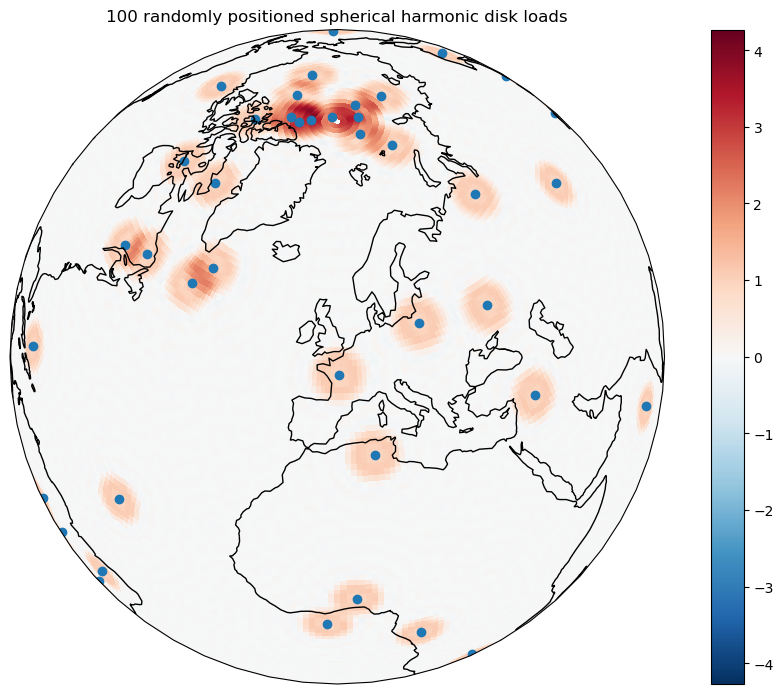

In [17]:

dadsks=dadskssh.sum("nlonlat").sh.synthesis()

proj=ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=50, satellite_height=35785831) 
fig, ax = plt.subplots(subplot_kw={'projection': proj},figsize=(12,8.5))

ax.coastlines()
dadsks.plot(ax=ax,transform=ccrs.PlateCarree())
gspnts.plot(ax=ax,transform=ccrs.PlateCarree())
ax.set_title("100 randomly positioned spherical harmonic disk loads")
plt.show()